### Redes Neurais Artificiais - IFES - PPCOMP
### Exercicio 03
### Descida de Gradiente e Taxa de Aprendizado
### Datasets: Breast Cancer,  Dummy datasets (*)

##### (*) Datasets gerados na atividade 2 da disciplina

In [63]:
import sklearn
import numpy as np
import pandas as pd
from io import StringIO
import sys

from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_classification

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import SGDClassifier

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed(74)

In [64]:
#Plot de Fronteira de decsião do SGD
#Referência: https://towardsdatascience.com/easily-visualize-scikit-learn-models-decision-boundaries-dd0fb3747508

def plot_decision_boundaries(X, y, model_class, **model_params):
    """
    Function to plot the decision boundaries of a classification model.
    This uses just the first two columns of the data for fitting 
    the model as we need to find the predicted value for every point in 
    scatter plot.
    Arguments:
            X: Feature data as a NumPy-type array.
            y: Label data as a NumPy-type array.
            model_class: A Scikit-learn ML estimator class 
            e.g. GaussianNB (imported from sklearn.naive_bayes) or
            LogisticRegression (imported from sklearn.linear_model)
            **model_params: Model parameters to be passed on to the ML estimator
    
    Typical code example:
            plt.figure()
            plt.title("KNN decision boundary with neighbros: 5",fontsize=16)
            plot_decision_boundaries(X_train,y_train,KNeighborsClassifier,n_neighbors=5)
            plt.show()
    """
    try:
        X = np.array(X)
        y = np.array(y).flatten()
    except:
        print("Coercing input data to NumPy arrays failed")
    # Reduces to the first two columns of data
    reduced_data = X[:, :2]
    # Instantiate the model object
    model = model_class(**model_params)
    # Fits the model with the reduced data
    model.fit(reduced_data, y)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].    

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    # Meshgrid creation
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh using the model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predictions to obtain the classification results
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Plotting
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    plt.xlabel("Feature-1",fontsize=15)
    plt.ylabel("Feature-2",fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    return plt

In [65]:
# Datasets Binários
# Numero de Features = 2 para melhor entendimento da fronteira de decisão
dX_AllDatasets={}
dy_AllDatasets={}
eta_AllDatasets={}


# Dummy Dataset 1 - sklearn.datasets.make_classification
# One informative feature, one cluster per class
X, y = make_classification(n_samples=100,n_features=2, n_redundant=0, n_informative=1,
                             n_clusters_per_class=1)
dX_AllDatasets['dummy_ds_1']=X
dy_AllDatasets['dummy_ds_1']=y
eta_AllDatasets['dummy_ds_1']=[0.02,0.1,0.5]

# Dummy Dataset 2 - sklearn.datasets.make_classification
# Two informative features, one cluster per class
X, y = make_classification(n_samples=100,n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1)
dX_AllDatasets['dummy_ds_2']=X
dy_AllDatasets['dummy_ds_2']=y
eta_AllDatasets['dummy_ds_2']=[0.02,0.1,0.5]

# Dummy Dataset 3 - sklearn.datasets.make_classification
# Two informative features, two clusters per class
X, Y = make_classification(n_samples=100,n_features=2, n_redundant=0, n_informative=2)
dX_AllDatasets['dummy_ds_3']=X
dy_AllDatasets['dummy_ds_3']=y
eta_AllDatasets['dummy_ds_3']=[0.02,0.1,0.5]

# Dummy Dataset 4 - sklearn.datasets.make_classification
# 10.000 Samples com 10% de "ruído"
X, y = make_classification(
    n_samples=100,
    n_features=2,
    n_redundant=0, n_informative=2,
    flip_y=0.1) 
dX_AllDatasets['dummy_ds_4_10_noise']=X
dy_AllDatasets['dummy_ds_4_10_noise']=y
eta_AllDatasets['dummy_ds_4_10_noise']=[0.02,0.1,0.5]

# Dummy Dataset 5 - sklearn.datasets.make_classification
# 10.000 Samples - Difícil separação
X, y = make_classification(
    n_samples=100,
    n_features=2,
    n_redundant=0, n_informative=2,
    class_sep=0.1) # class_sep padrão=1.0. Menor o valor, mais dificil a classificação
dX_AllDatasets['dummy_ds_5_hard_sep']=X
dy_AllDatasets['dummy_ds_5_hard_sep']=y
eta_AllDatasets['dummy_ds_5_hard_sep']=[0.02,0.1,0.5]

In [66]:
 X,y=dX_AllDatasets['dummy_ds_1'],dy_AllDatasets['dummy_ds_1']

In [67]:
def PlotFeatures(X,y):
    colors = ['purple','yellow']
    cmap=mpl.colors.ListedColormap(colors)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=mpl.colors.ListedColormap(colors))
    plt.xlabel("$Feature-1$", fontsize=18)
    plt.ylabel("$Feature-2$", rotation=90, fontsize=18)
    plt.axis([-3, 3, -3, 3])
    plt.show()

In [68]:
loss_functions=['hinge','log','squared_hinge','perceptron']
epochs=1000
i_no_change=200

In [69]:
def runSGD(DatasetKey):
    key=DatasetKey
    old_stdout = sys.stdout
    print("\n" +"="*40)
    print(key)
    print("-"*40)
    X,y=dX_AllDatasets[key],dy_AllDatasets[key]
    eta=0.5
    for lf in loss_functions:
        for eta in eta_AllDatasets[key]:
            sys.stdout = mystdout = StringIO() # Altera stdout para capturar saidas do classificador em modo verbose
            clf=SGDClassifier(n_iter_no_change=i_no_change,early_stopping=False,max_iter=epochs,loss=lf, eta0=eta, learning_rate="constant", penalty=None,verbose=1)
            clf.fit(X,y)

            # Captura a evolução do custo (loss values) das saidas do modo verbose
            loss_history = mystdout.getvalue()
            loss_list = []
            for line in loss_history.split('\n'):
                if(len(line.split("loss: ")) == 1):
                    continue
                loss_list.append(float(line.split("loss: ")[-1]))        
            scores=cross_val_score(clf, X,y, cv=5)
            sys.stdout = old_stdout # volta com stdout para o padrão para impressão das métricas        

            print('LF: %15s eta:%0.3f Mean: %0.7f Std: %0.7f(+/-)' % (lf, eta, scores.mean(), scores.std()))
            PlotFeatures(X,y)

            plt.figure()
            plt.plot(np.arange(len(loss_list)), loss_list)
            plt.xlabel("Iterações"); plt.ylabel("Loss")
            plt.show()

            plt.figure()
            plot_decision_boundaries(X, y, SGDClassifier, n_iter_no_change=i_no_change,early_stopping=False,max_iter=epochs,loss=lf, eta0=eta, learning_rate="constant", penalty=None)
            plt.show()



dummy_ds_1
----------------------------------------
LF:           hinge eta:0.020 Mean: 0.9900000 Std: 0.0200000(+/-)


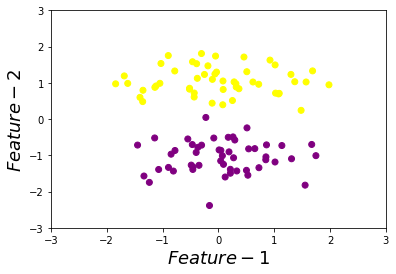

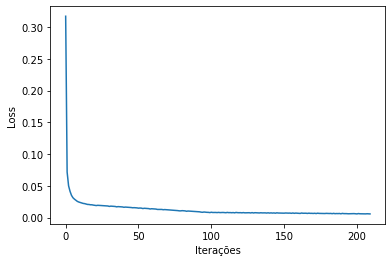

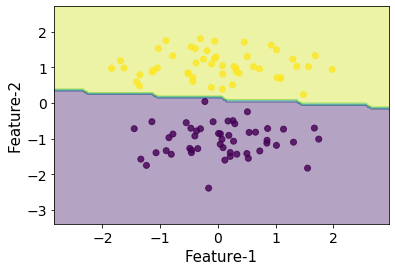

LF:           hinge eta:0.100 Mean: 0.9900000 Std: 0.0200000(+/-)


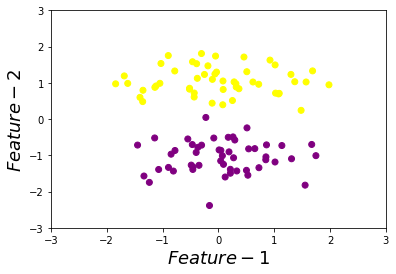

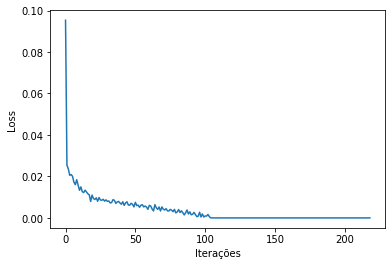

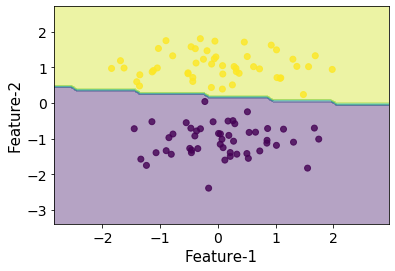

LF:           hinge eta:0.500 Mean: 0.9900000 Std: 0.0200000(+/-)


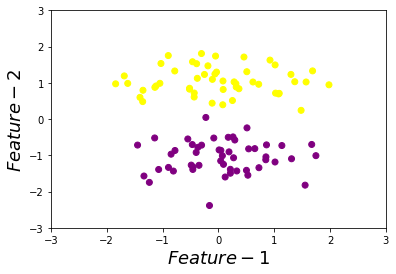

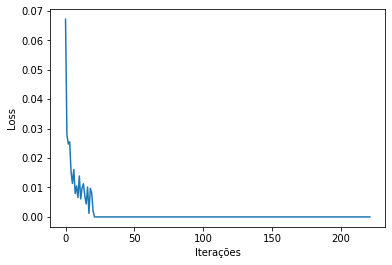

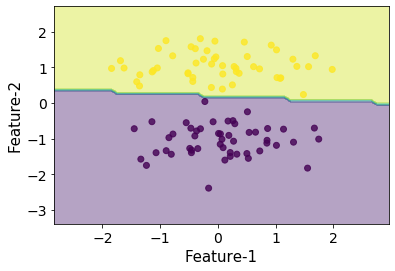

LF:             log eta:0.020 Mean: 0.9900000 Std: 0.0200000(+/-)


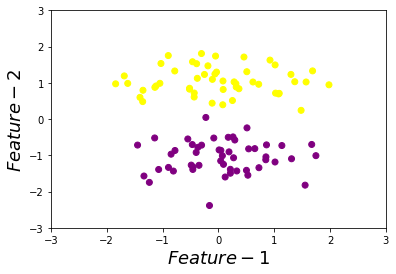

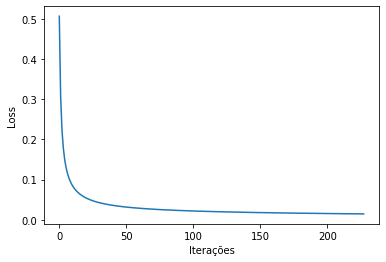

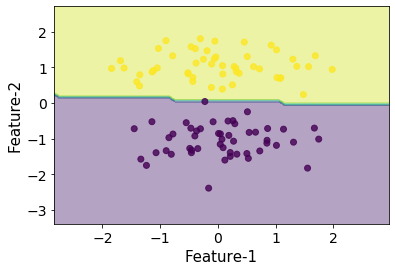

LF:             log eta:0.100 Mean: 0.9900000 Std: 0.0200000(+/-)


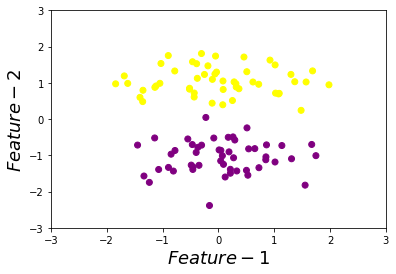

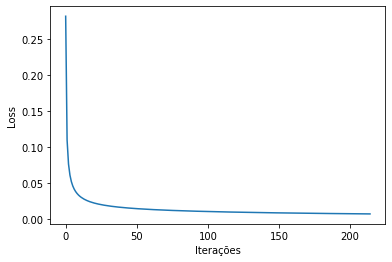

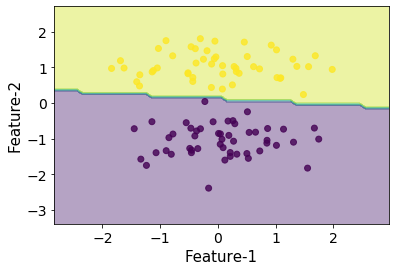

LF:             log eta:0.500 Mean: 0.9900000 Std: 0.0200000(+/-)


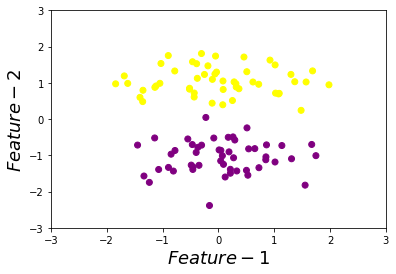

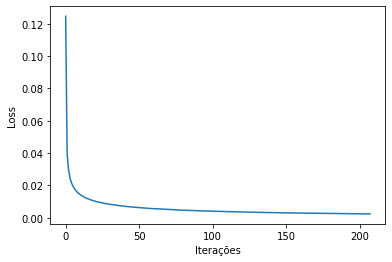

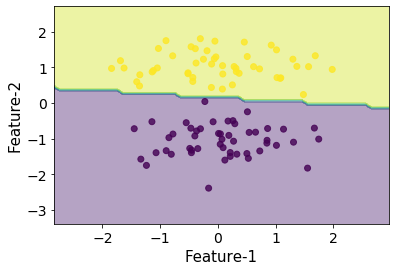

LF:   squared_hinge eta:0.020 Mean: 0.9900000 Std: 0.0200000(+/-)


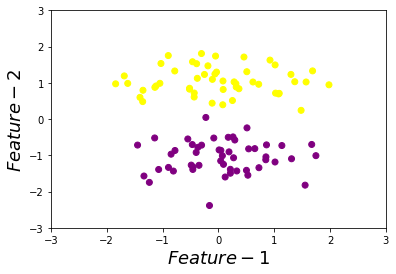

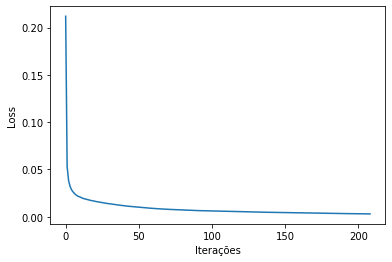

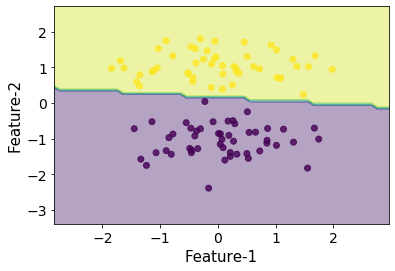

LF:   squared_hinge eta:0.100 Mean: 0.9800000 Std: 0.0400000(+/-)


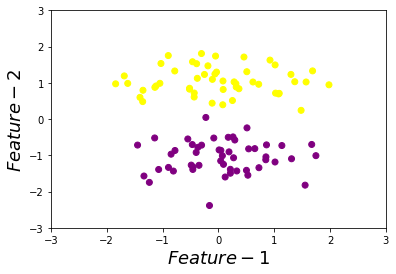

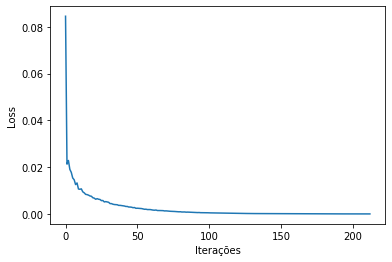

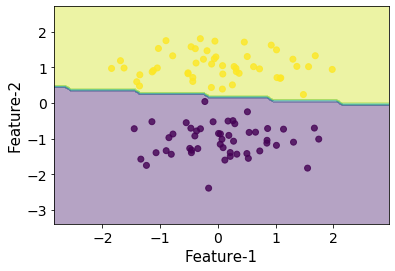

LF:   squared_hinge eta:0.500 Mean: 0.9800000 Std: 0.0244949(+/-)


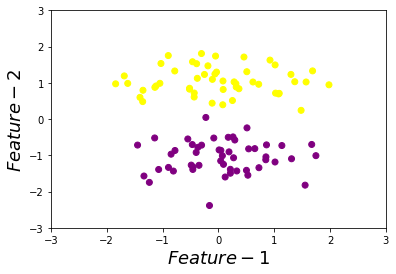

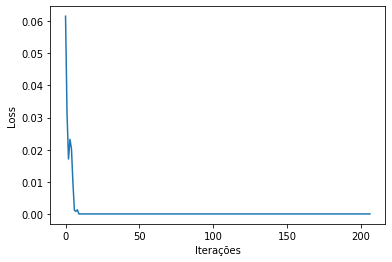

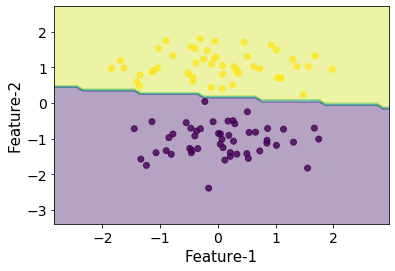

LF:      perceptron eta:0.020 Mean: 0.9600000 Std: 0.0374166(+/-)


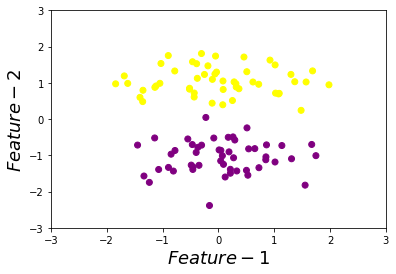

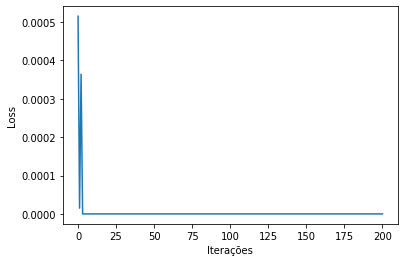

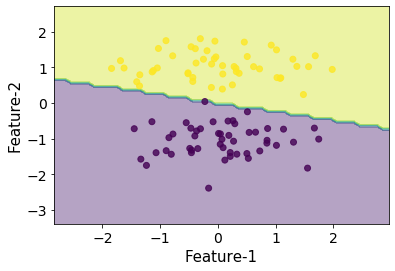

LF:      perceptron eta:0.100 Mean: 0.9700000 Std: 0.0400000(+/-)


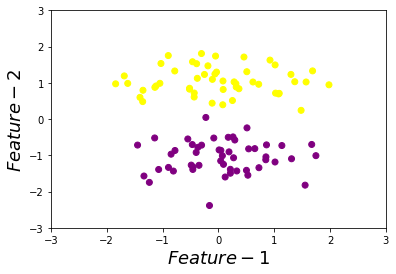

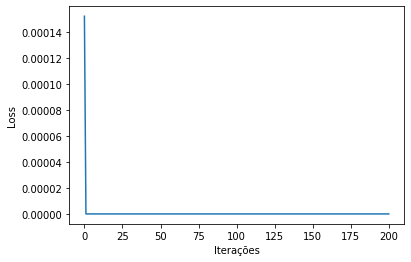

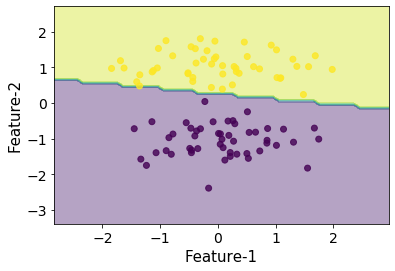

LF:      perceptron eta:0.500 Mean: 0.9800000 Std: 0.0244949(+/-)


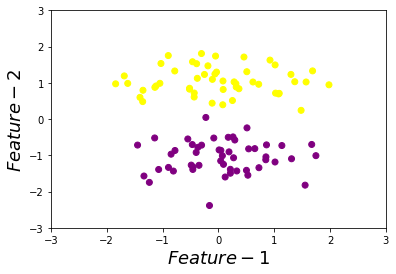

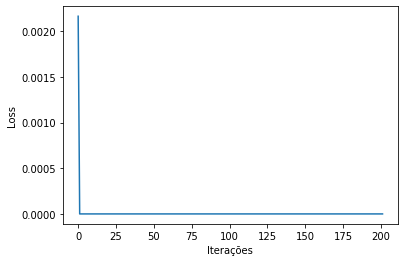

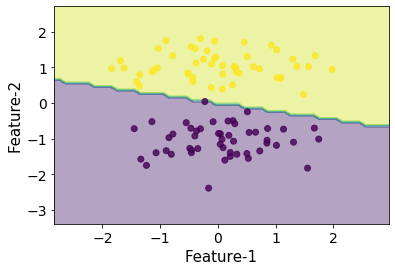

In [70]:
key='dummy_ds_1'
runSGD(key)


dummy_ds_2
----------------------------------------
LF:           hinge eta:0.020 Mean: 0.9799499 Std: 0.0246074(+/-)


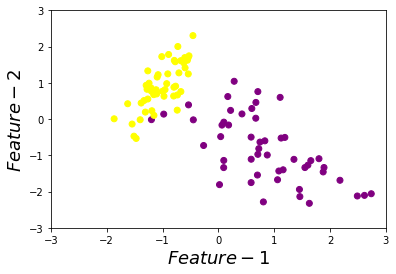

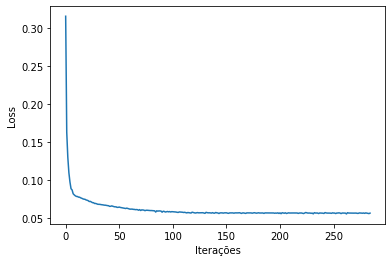

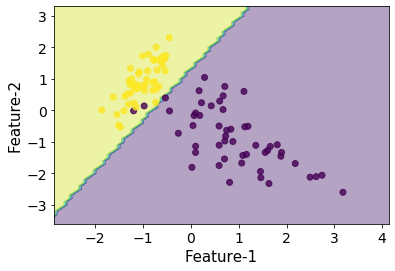

LF:           hinge eta:0.100 Mean: 0.9599499 Std: 0.0200878(+/-)


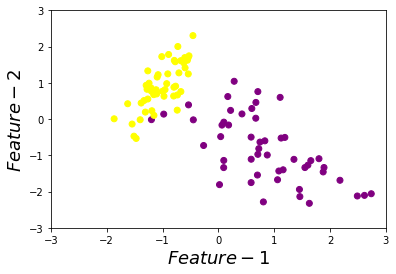

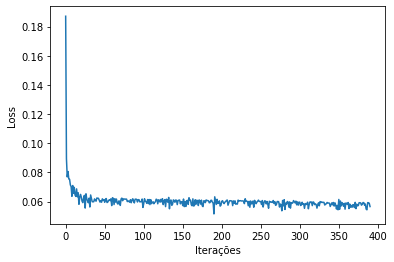

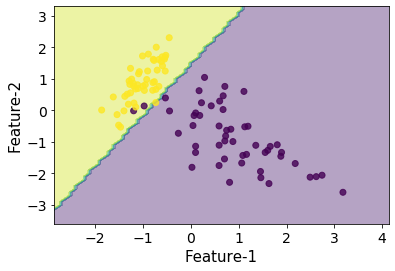

LF:           hinge eta:0.500 Mean: 0.9699499 Std: 0.0245870(+/-)


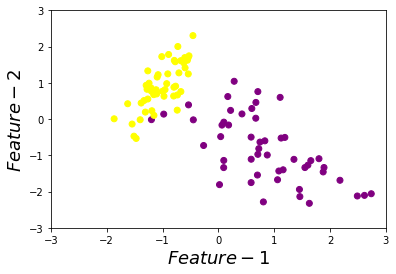

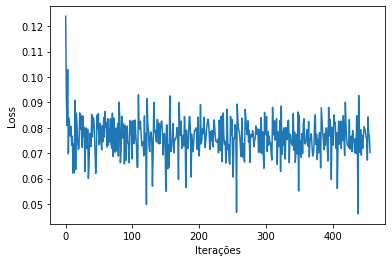

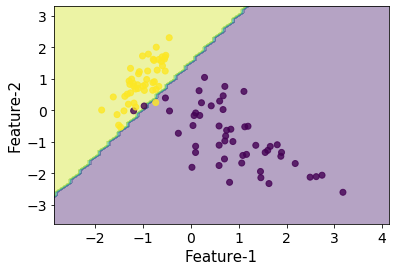

LF:             log eta:0.020 Mean: 0.9699499 Std: 0.0245870(+/-)


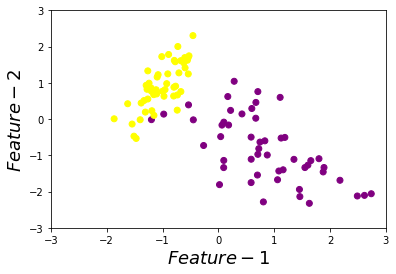

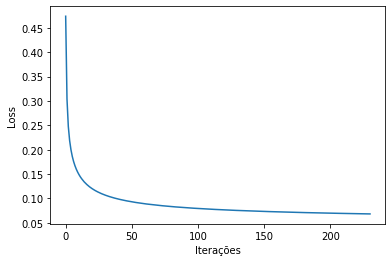

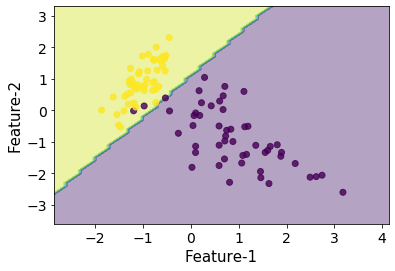

LF:             log eta:0.100 Mean: 0.9599499 Std: 0.0200878(+/-)


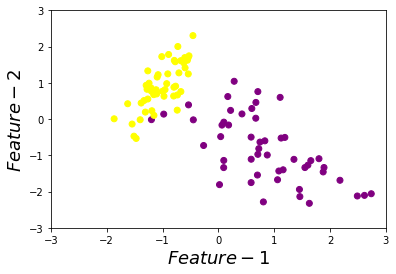

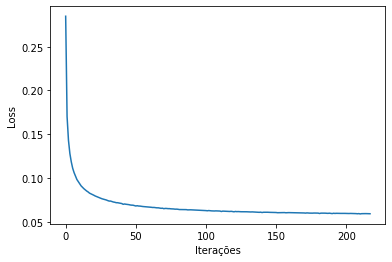

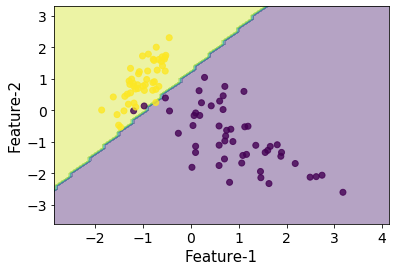

LF:             log eta:0.500 Mean: 0.9699499 Std: 0.0245870(+/-)


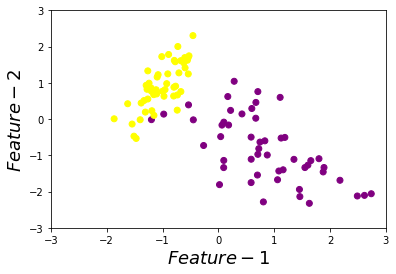

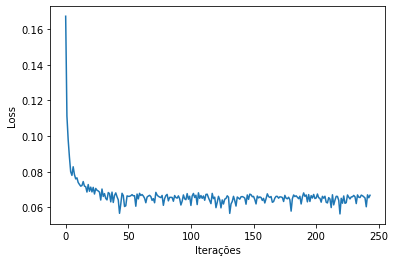

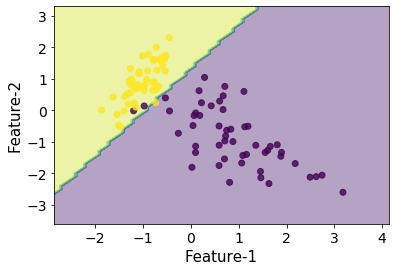

LF:   squared_hinge eta:0.020 Mean: 0.9699499 Std: 0.0245870(+/-)


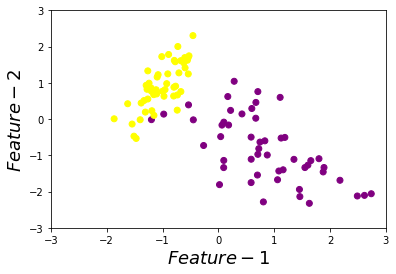

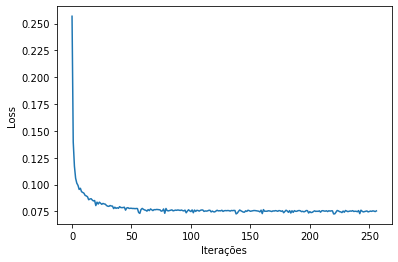

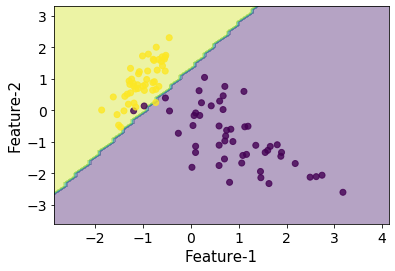

LF:   squared_hinge eta:0.100 Mean: 0.9604762 Std: 0.0373012(+/-)


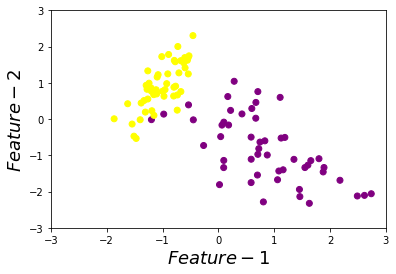

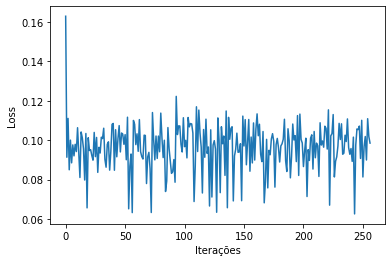

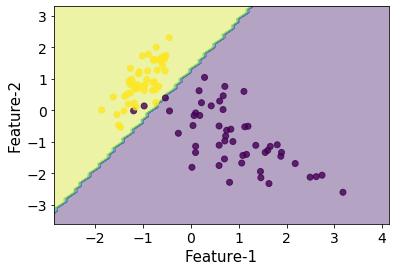

LF:   squared_hinge eta:0.500 Mean: 0.9399499 Std: 0.0200378(+/-)


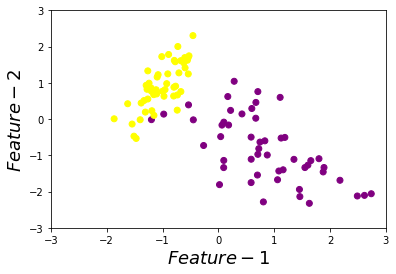

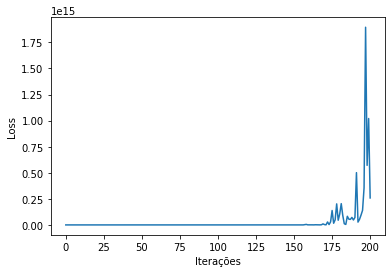

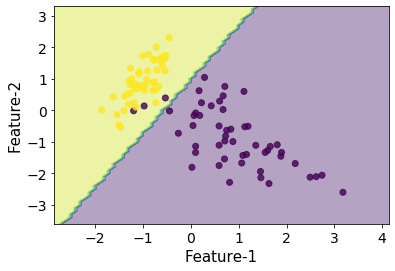

LF:      perceptron eta:0.020 Mean: 0.9604762 Std: 0.0373012(+/-)


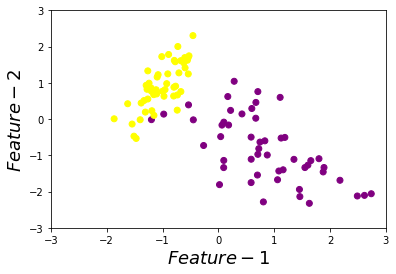

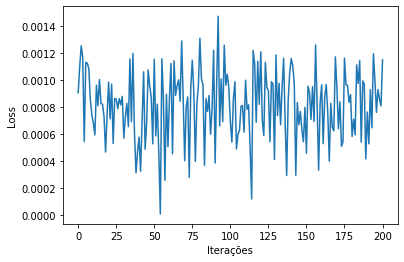

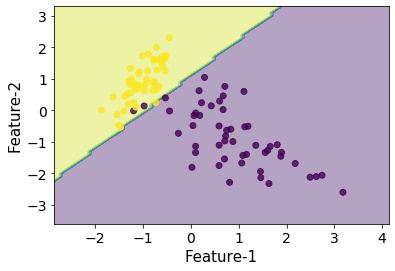

LF:      perceptron eta:0.100 Mean: 0.9599499 Std: 0.0200878(+/-)


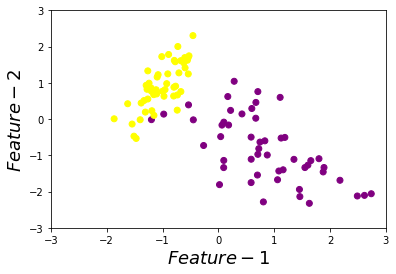

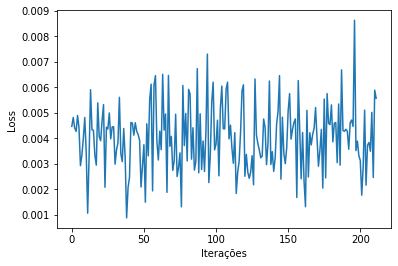

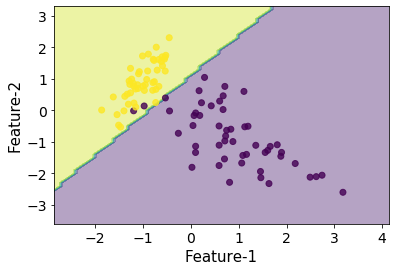

LF:      perceptron eta:0.500 Mean: 0.9599499 Std: 0.0200878(+/-)


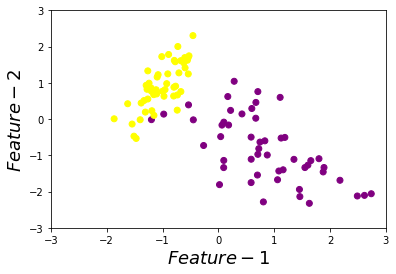

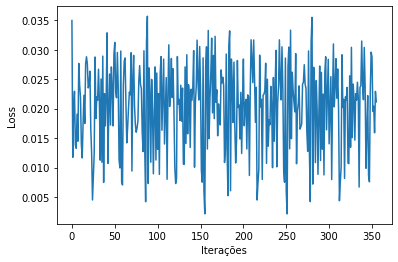

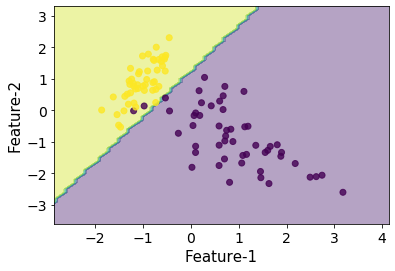

In [71]:
key='dummy_ds_2'
runSGD(key)


dummy_ds_3
----------------------------------------
LF:           hinge eta:0.020 Mean: 0.4894987 Std: 0.0513966(+/-)


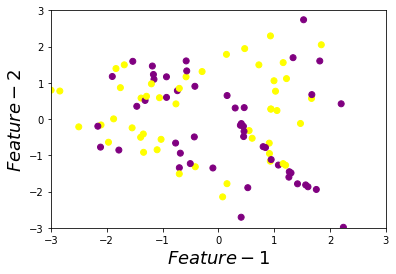

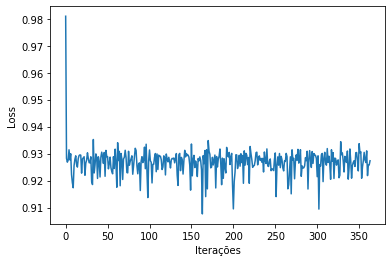

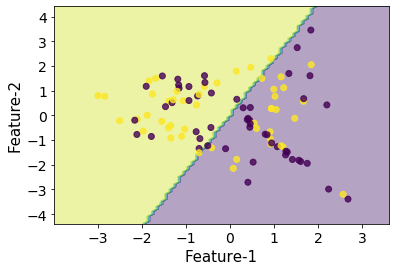

LF:           hinge eta:0.100 Mean: 0.4789724 Std: 0.0376531(+/-)


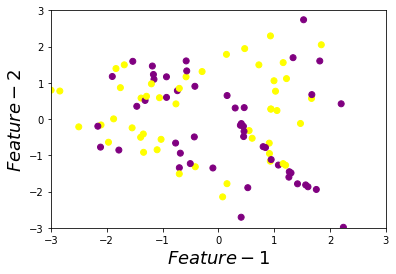

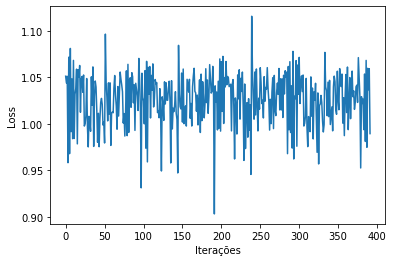

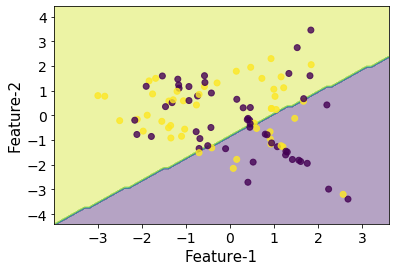

LF:           hinge eta:0.500 Mean: 0.4900251 Std: 0.0717801(+/-)


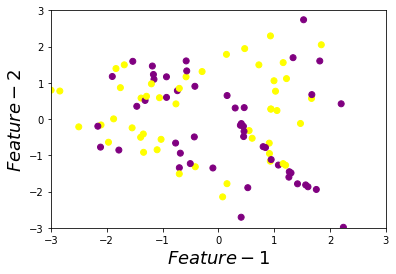

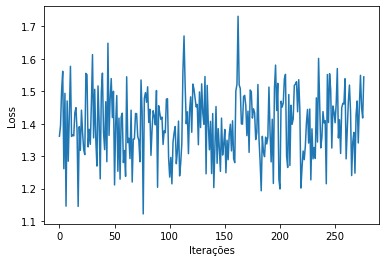

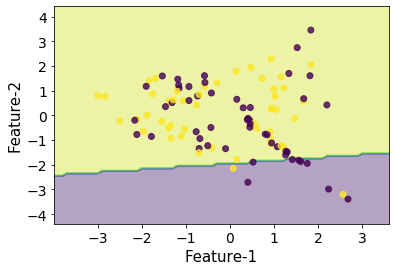

LF:             log eta:0.020 Mean: 0.5089724 Std: 0.0792427(+/-)


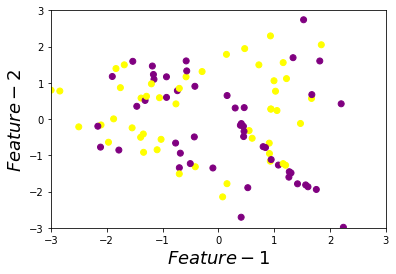

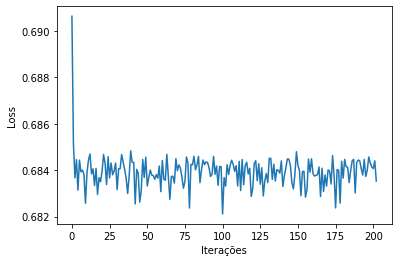

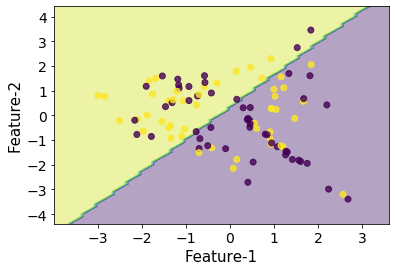

LF:             log eta:0.100 Mean: 0.5600251 Std: 0.0561148(+/-)


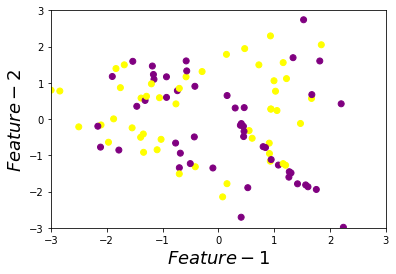

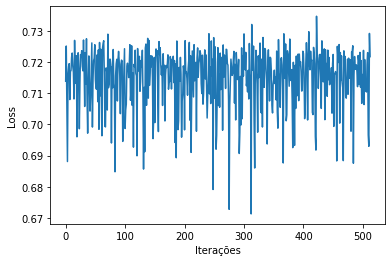

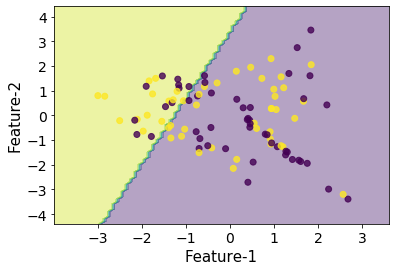

LF:             log eta:0.500 Mean: 0.4890226 Std: 0.0635485(+/-)


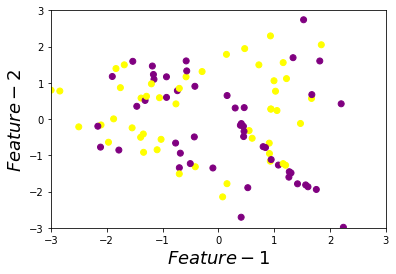

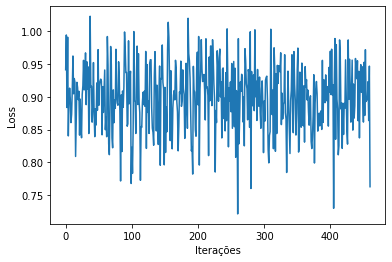

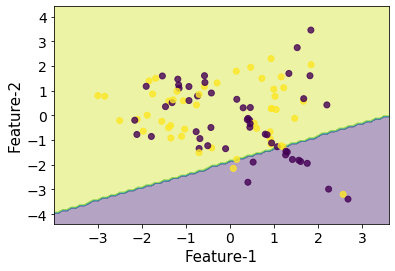

LF:   squared_hinge eta:0.020 Mean: 0.5695489 Std: 0.0426833(+/-)


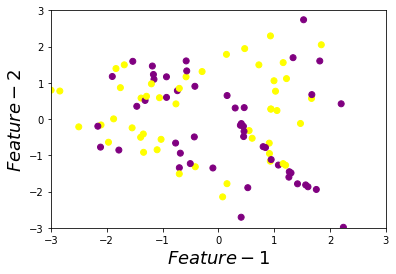

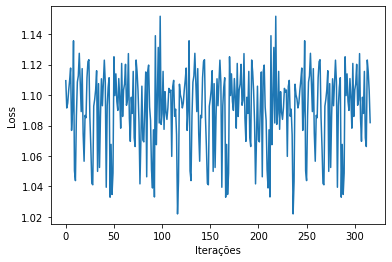

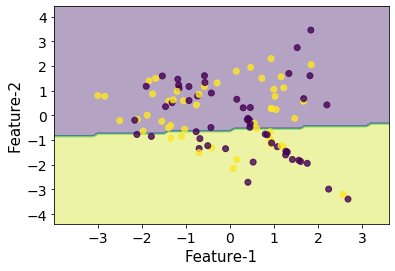

LF:   squared_hinge eta:0.100 Mean: 0.4409273 Std: 0.0705931(+/-)


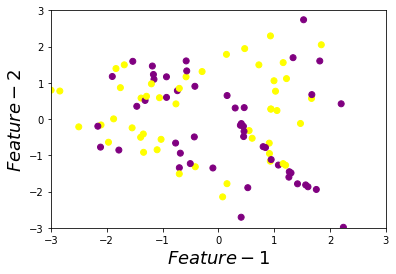

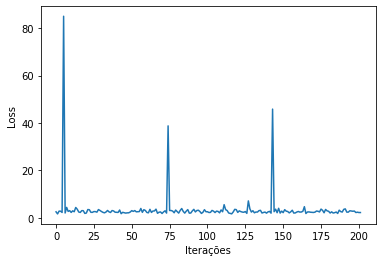

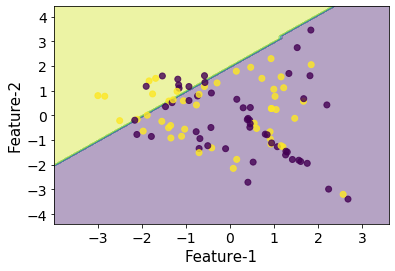

LF:   squared_hinge eta:0.500 Mean: 0.5199749 Std: 0.0659764(+/-)


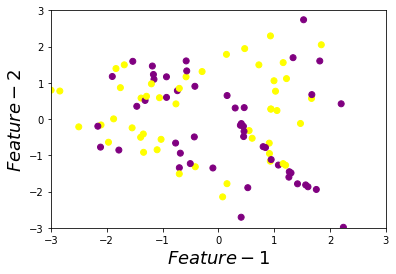

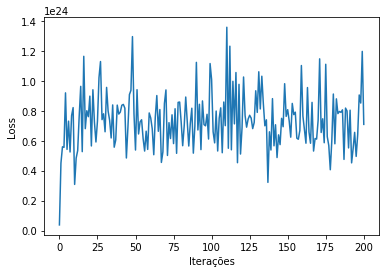

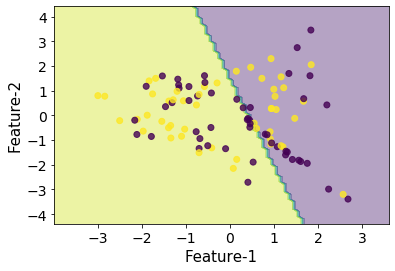

LF:      perceptron eta:0.020 Mean: 0.5705013 Std: 0.0989012(+/-)


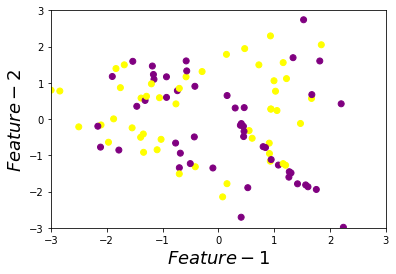

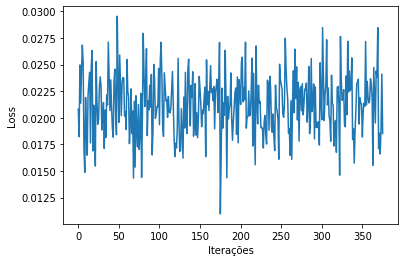

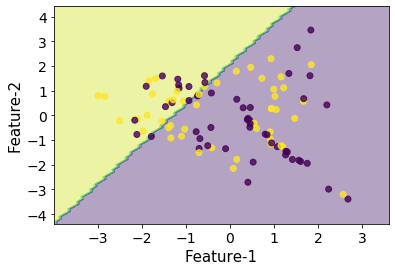

LF:      perceptron eta:0.100 Mean: 0.4605013 Std: 0.0607596(+/-)


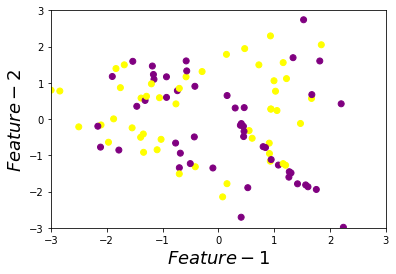

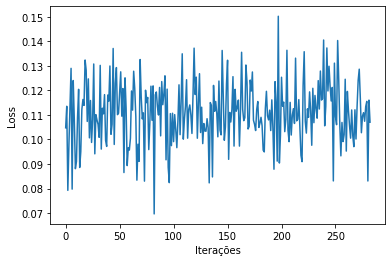

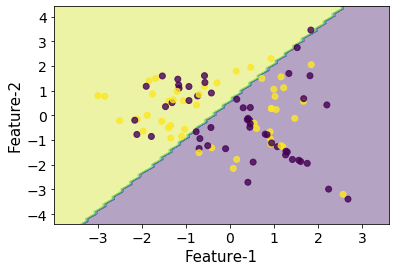

LF:      perceptron eta:0.500 Mean: 0.5195990 Std: 0.0818345(+/-)


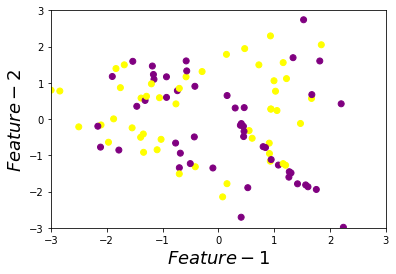

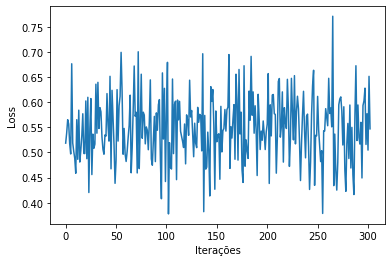

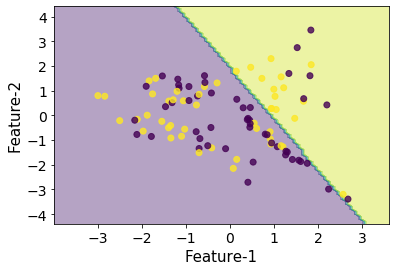

In [72]:
key='dummy_ds_3'
runSGD(key)


dummy_ds_4_10_noise
----------------------------------------
LF:           hinge eta:0.020 Mean: 0.8313784 Std: 0.0661591(+/-)


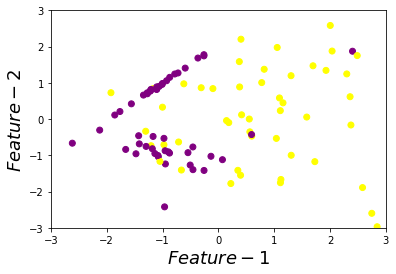

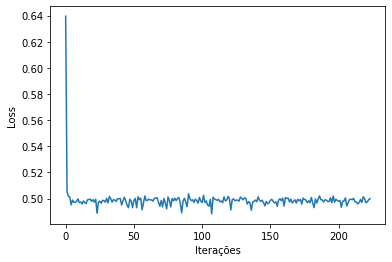

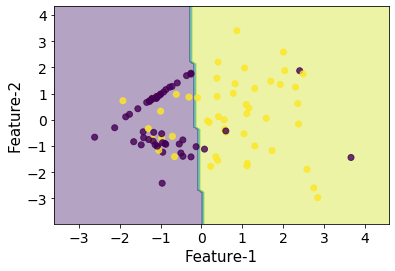

LF:           hinge eta:0.100 Mean: 0.8003759 Std: 0.0703416(+/-)


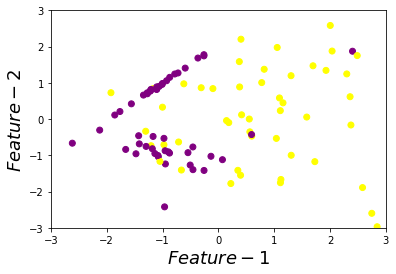

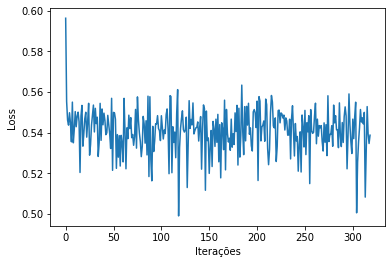

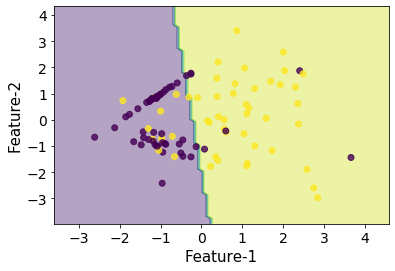

LF:           hinge eta:0.500 Mean: 0.7188471 Std: 0.1209602(+/-)


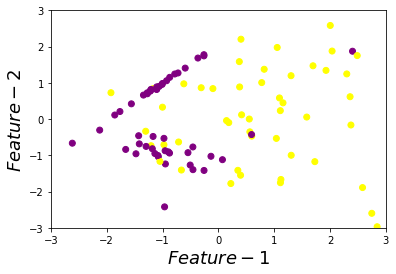

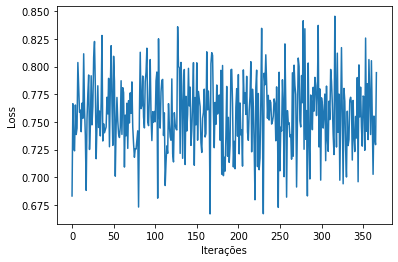

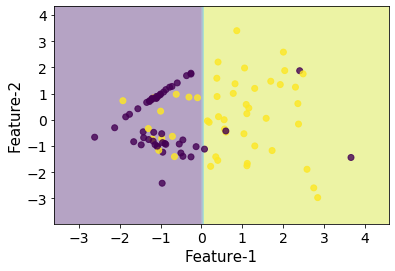

LF:             log eta:0.020 Mean: 0.8313784 Std: 0.0661591(+/-)


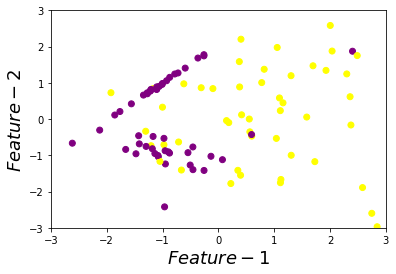

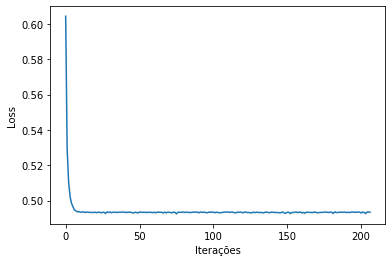

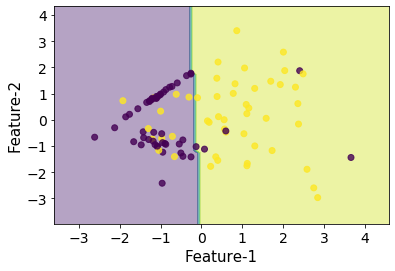

LF:             log eta:0.100 Mean: 0.8509023 Std: 0.0539028(+/-)


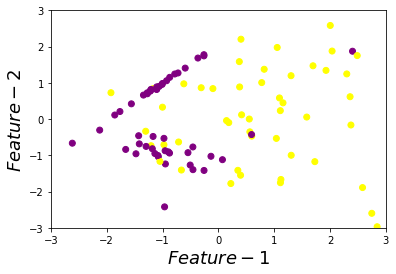

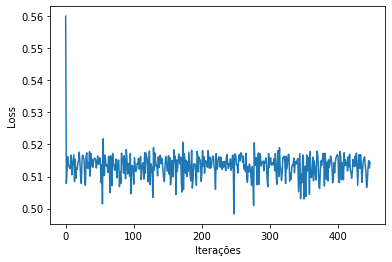

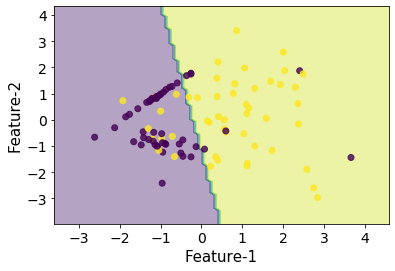

LF:             log eta:0.500 Mean: 0.8403759 Std: 0.0363023(+/-)


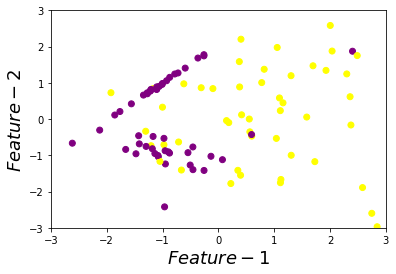

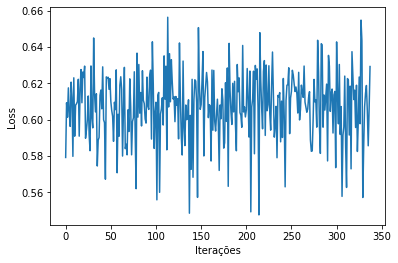

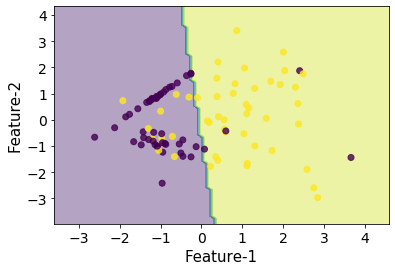

LF:   squared_hinge eta:0.020 Mean: 0.8208521 Std: 0.0487683(+/-)


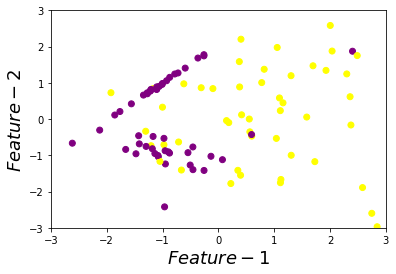

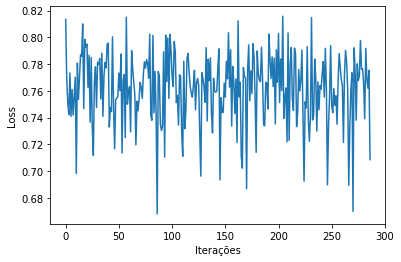

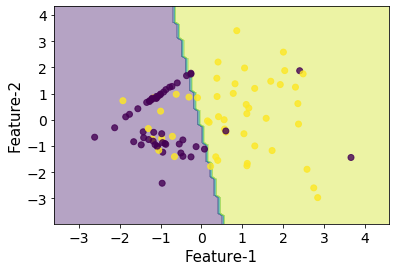

LF:   squared_hinge eta:0.100 Mean: 0.7232832 Std: 0.1533192(+/-)


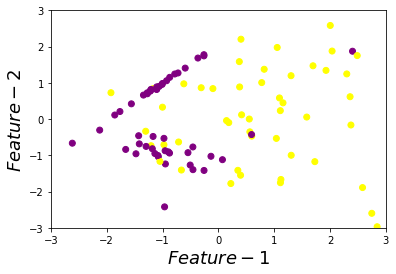

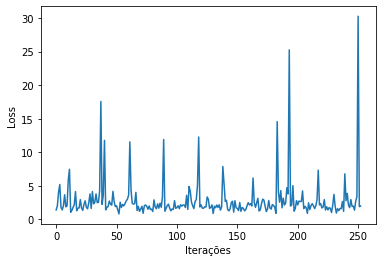

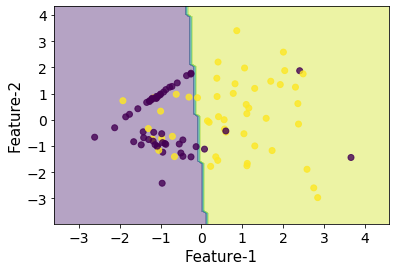

LF:   squared_hinge eta:0.500 Mean: 0.7793233 Std: 0.0758136(+/-)


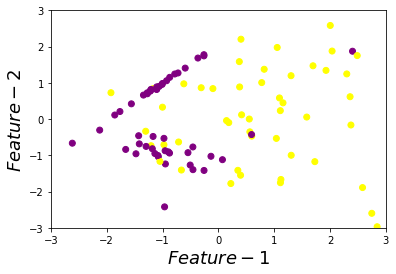

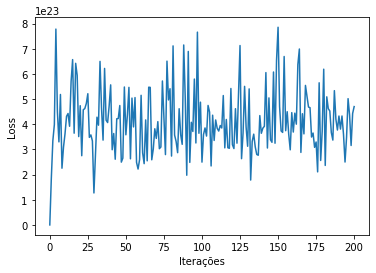

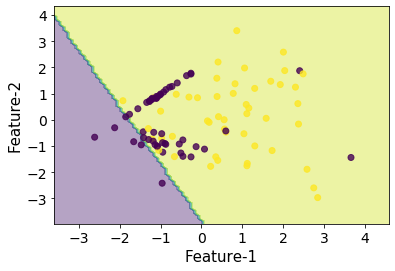

LF:      perceptron eta:0.020 Mean: 0.8423810 Std: 0.0836308(+/-)


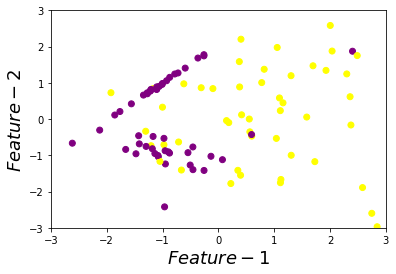

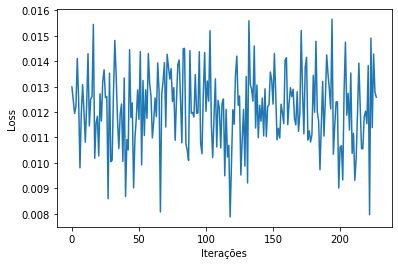

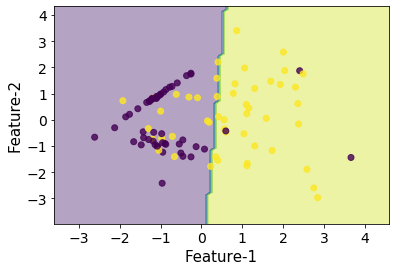

LF:      perceptron eta:0.100 Mean: 0.7322807 Std: 0.0881173(+/-)


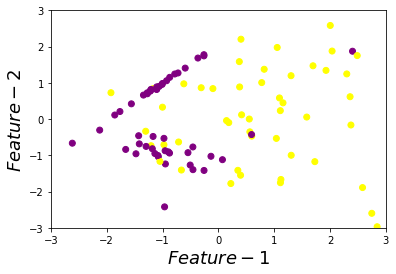

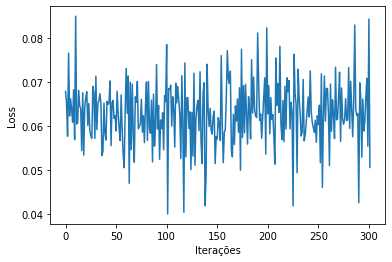

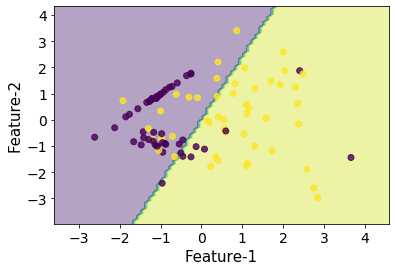

LF:      perceptron eta:0.500 Mean: 0.7438095 Std: 0.1427984(+/-)


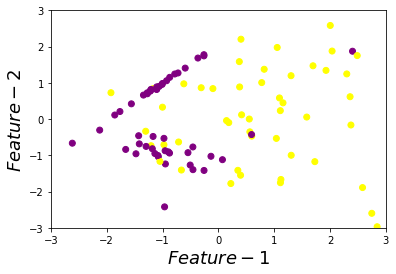

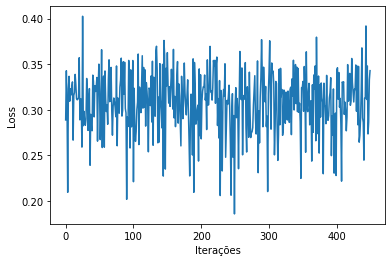

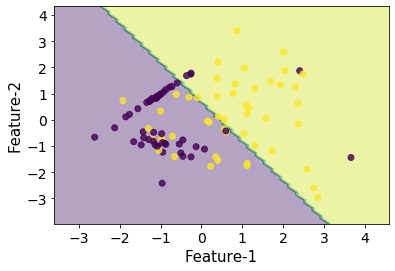

In [73]:
key='dummy_ds_4_10_noise'
runSGD(key)


dummy_ds_5_hard_sep
----------------------------------------
LF:           hinge eta:0.020 Mean: 0.4500000 Std: 0.1140175(+/-)


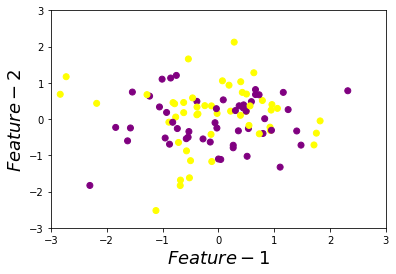

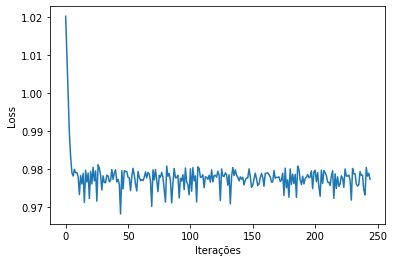

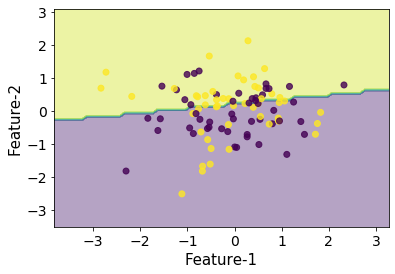

LF:           hinge eta:0.100 Mean: 0.5300000 Std: 0.0678233(+/-)


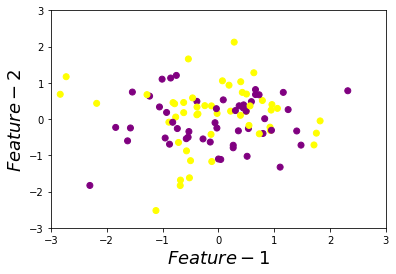

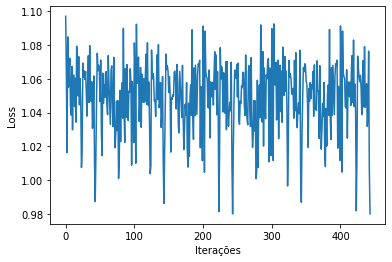

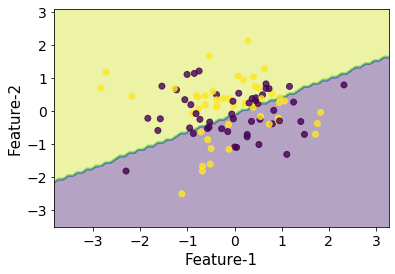

LF:           hinge eta:0.500 Mean: 0.3400000 Std: 0.0489898(+/-)


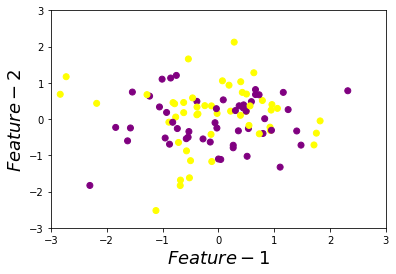

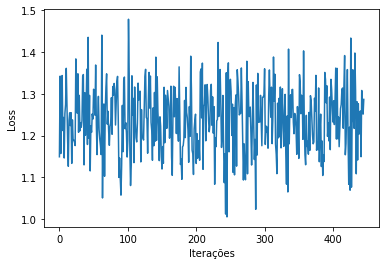

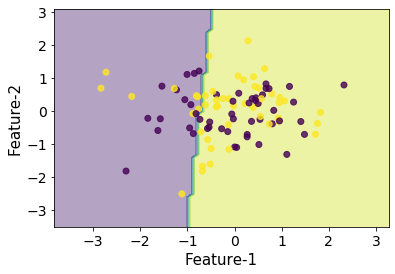

LF:             log eta:0.020 Mean: 0.5000000 Std: 0.0894427(+/-)


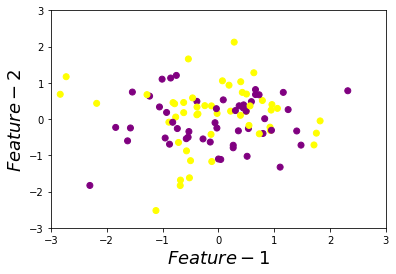

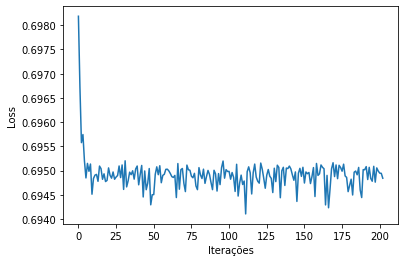

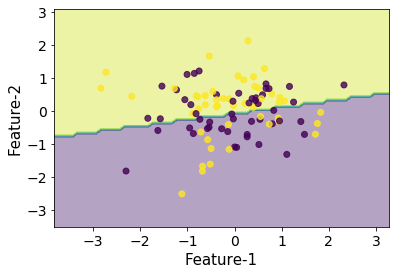

LF:             log eta:0.100 Mean: 0.4400000 Std: 0.0663325(+/-)


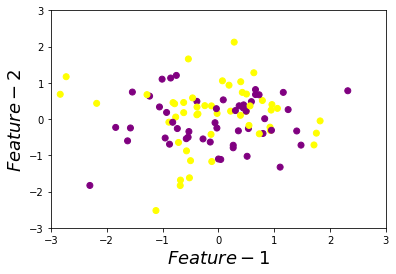

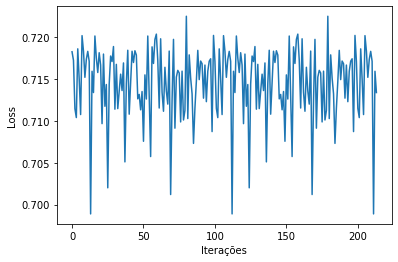

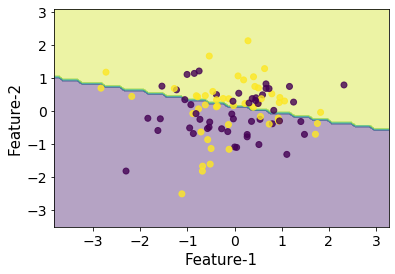

LF:             log eta:0.500 Mean: 0.4400000 Std: 0.0969536(+/-)


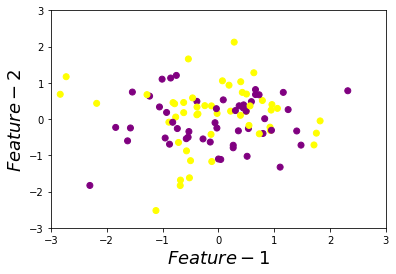

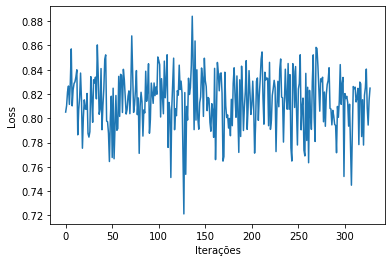

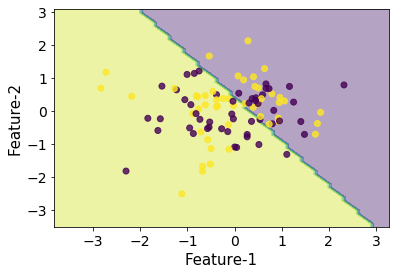

LF:   squared_hinge eta:0.020 Mean: 0.5000000 Std: 0.0632456(+/-)


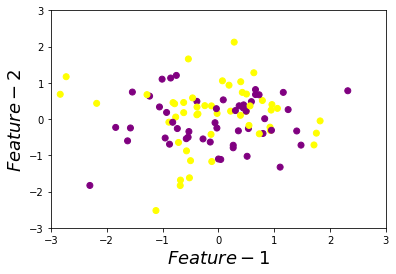

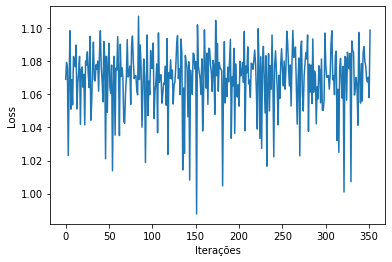

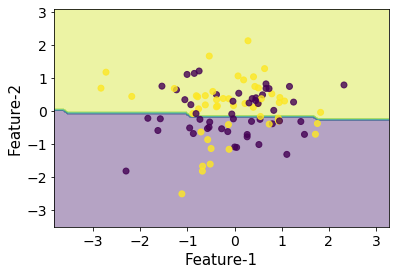

LF:   squared_hinge eta:0.100 Mean: 0.5200000 Std: 0.0927362(+/-)


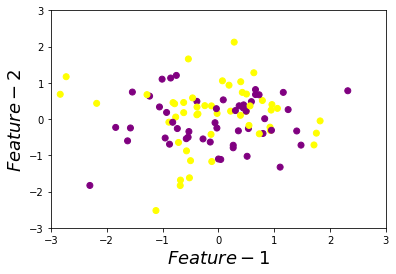

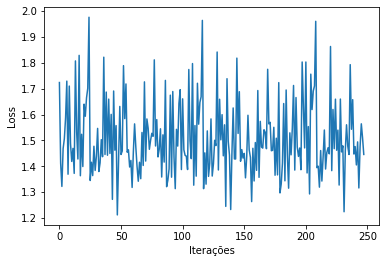

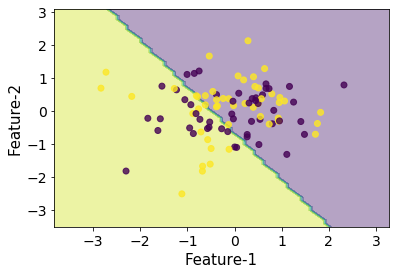

LF:   squared_hinge eta:0.500 Mean: 0.3900000 Std: 0.0374166(+/-)


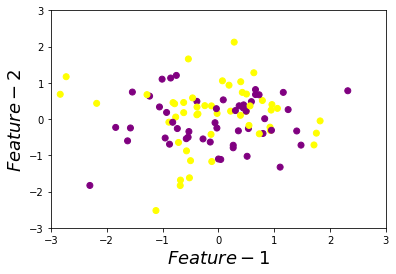

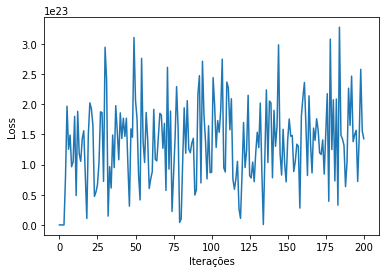

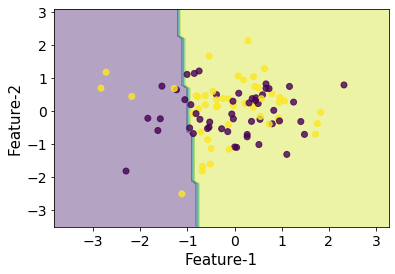

LF:      perceptron eta:0.020 Mean: 0.5100000 Std: 0.1019804(+/-)


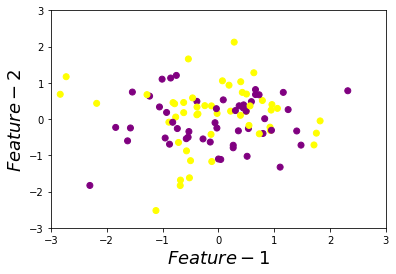

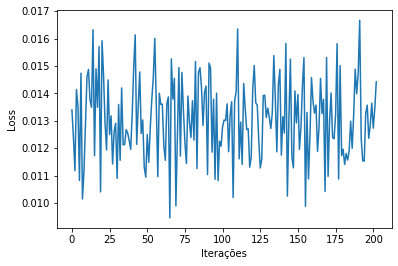

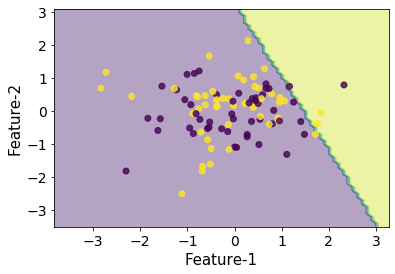

LF:      perceptron eta:0.100 Mean: 0.4400000 Std: 0.0969536(+/-)


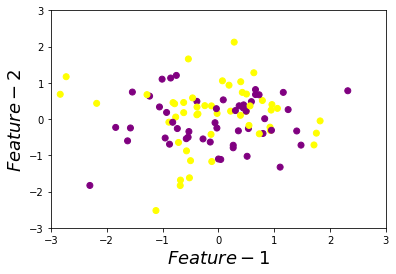

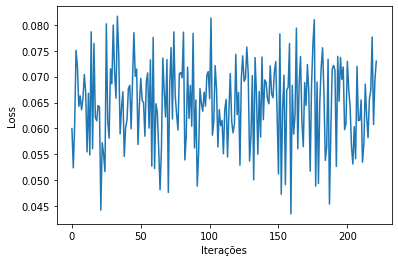

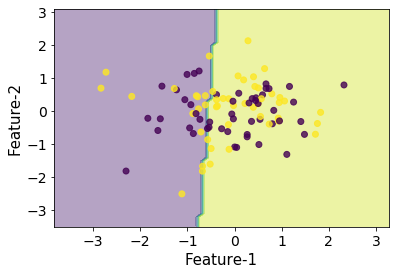

LF:      perceptron eta:0.500 Mean: 0.4600000 Std: 0.0860233(+/-)


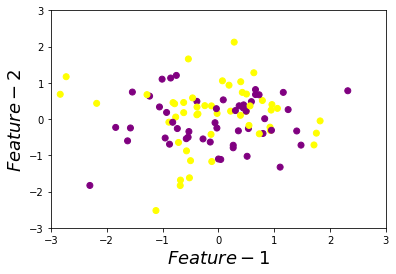

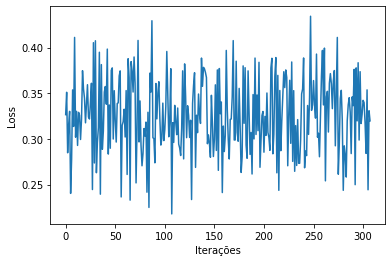

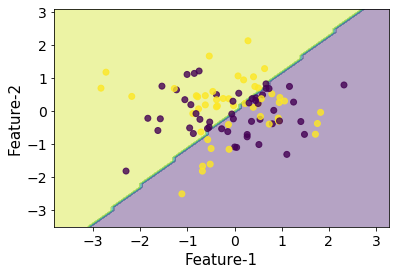

In [74]:
key='dummy_ds_5_hard_sep'
runSGD(key)